In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
target = ['activity']

X_train = pd.read_csv('samsung_train.txt', delim_whitespace=True, header=None)
X_train.columns = pd.read_csv('features.txt', delim_whitespace=True, header=None)[1]
y_train = pd.read_csv('samsung_train_labels.txt', header=None, names=target)

X_test = pd.read_csv('samsung_test.txt', delim_whitespace=True, header=None)
X_test.columns = pd.read_csv('features.txt', delim_whitespace=True, header=None)[1]
y_test = pd.read_csv('samsung_test_labels.txt', header=None, names=target)

C:\Users\marci\AppData\Local\Temp\ipykernel_10012\2069455671.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('samsung_train.txt', delim_whitespace=True, header=None)
C:\Users\marci\AppData\Local\Temp\ipykernel_10012\2069455671.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train.columns = pd.read_csv('features.txt', delim_whitespace=True, header=None)[1]
C:\Users\marci\AppData\Local\Temp\ipykernel_10012\2069455671.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('samsung_test.txt', delim_whitespace=True, header=None)
C:\Users\marci\AppData\Local\Temp\ipykernel_10012\2069455671.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_cs

In [3]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

**Przygotowanie danych**

1. Czy potrzeba wszystkich cech?
**ODP: Domyślnie zakładamy, że wszystkie cechy są ważne i potrzebne. Dopiero porównując działanie modelu na pierwotnych/pełnych danych z modele działającym na danych zredukowanych będziemy w stanie powiedzieć czy wszystkie dane są potrzebne. Odpowiedź poznamy w dalszej części zadania.**

2. Czy potrzebna jest jakaś obróbka? **ODP: Zgonie z informacją dane są znormalizowane [-1,1], jednak to nie to samo co standaryzacja gdzie średnia to 0, a std to 1. W związku z tym wystandaryzujemy dane w zbiorze treningowym.**

3. Czy wiemy, jak obrobić? **ODP: Tak, dokonamy standaryzacji - [KROK PIERWSZY], następnie dokonamy redukcji wymiarów [KROK DRUGI]**

4. Czy wiemy, co jaka cecha znaczy? **ODP: Tak. Dane surowe pochodzą z dwóch urządzeń, tą to dane trójosiowe z akcelerometra i żyroskopu. Dane zarejestrowane z częstotliwością 50 Hz a następnie został przefiltrowane celem usunięcia szumów - okno czasowe to 2,56 s. W zbiorze cech znajduje się 17 cech z których określono zmienne typu mean(), std () itd oraz dodatkowe wektory - angle(). Dane są wynikiem eksperymentu w którym wzięło 30 uczestników, którzy rejestrowali 6 różnych aktywności.**

5. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego? **ODP: Podział danych na testowy i treningowy nie jest potrzebny w klasteryzacji. Zbiory treningowe i testowe to domena uczenia nadzorowanego, jeśli chodzi o klasteryzację to warto mieć jeden zbiór X - zawierający wartości niezależne.**

**[KROK PIERWSZY] - skalujemy dane w zbiorze X_train**

In [4]:
scaler = StandardScaler()

X_scaled =  scaler.fit_transform(X)

**[DRUGI KROK] - dokonujemy redukcji wymiarów zbioru X_train_scaled metodą PCA do dwóch głównych składowych, tak aby możliwa była wizualizacja klasteryzacji 2D**

In [5]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

**Wizualizujemy wyjaśnoną wariancję i skumulowaną wyjaśnioną wariancję dla dwóch pierwszych składowych oraz wyliczamy ich wartości**

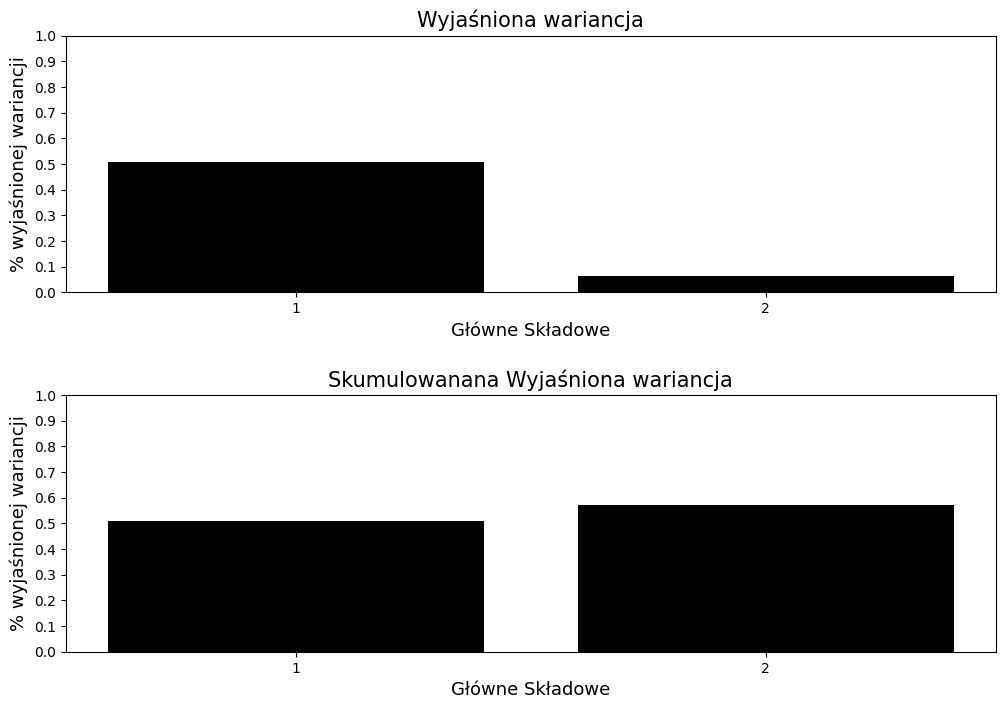

Główna składowa: 1, Wyjaśniona wariancja: 0.50738, Skumulowana Wyjaśniona wariancja: 0.50738
Główna składowa: 2, Wyjaśniona wariancja: 0.06239, Skumulowana Wyjaśniona wariancja: 0.56977


In [6]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=.4, hspace=.4)
ax = fig.add_subplot(2, 1, 1)
ax.bar(range(1, 1+pca.n_components_), pca.explained_variance_ratio_, color='black')
ax.set(xticks=[1, 2])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Wyjaśniona wariancja', fontsize=15)
plt.xlabel('Główne Składowe', fontsize=13)
plt.ylabel('% wyjaśnionej wariancji', fontsize=13)
ax = fig.add_subplot(2, 1, 2)
ax.bar(range(1, 1+pca.n_components_), np.cumsum(pca.explained_variance_ratio_), color='black')
ax.set(xticks=[1, 2])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Skumulowanana Wyjaśniona wariancja', fontsize=15)
plt.xlabel('Główne Składowe', fontsize=13)
plt.ylabel('% wyjaśnionej wariancji', fontsize=13)
plt.show()

principal_component = 1
cum_explained_var = 0
for explained_var in pca.explained_variance_ratio_:
    cum_explained_var += explained_var
    print(f'Główna składowa: {principal_component}, Wyjaśniona wariancja: {np.round(explained_var, 5)}, Skumulowana Wyjaśniona wariancja: {np.round(cum_explained_var, 5)}')
    principal_component += 1

In [7]:
print(f'KOMENTARZ: dwie pierwsze składowe wyjaśniają wariancję w {np.round((cum_explained_var*100),2)} % - jest to dość słaby wynik.')

KOMENTARZ: dwie pierwsze składowe wyjaśniają wariancję w 56.98 % - jest to dość słaby wynik.


**Definiujemy funkcje do wizualizacji wyników klasteryzacji**

In [8]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [9]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [10]:
def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

**[KMEANS] - dokonajmy klasteryzacji za pomocą modelu - KMeans z parametrem 6 klastrów.**

In [11]:
clf_kmeans = KMeans(n_clusters=6)
clf_kmeans.fit(X_pca)

KMeans(n_clusters=6)

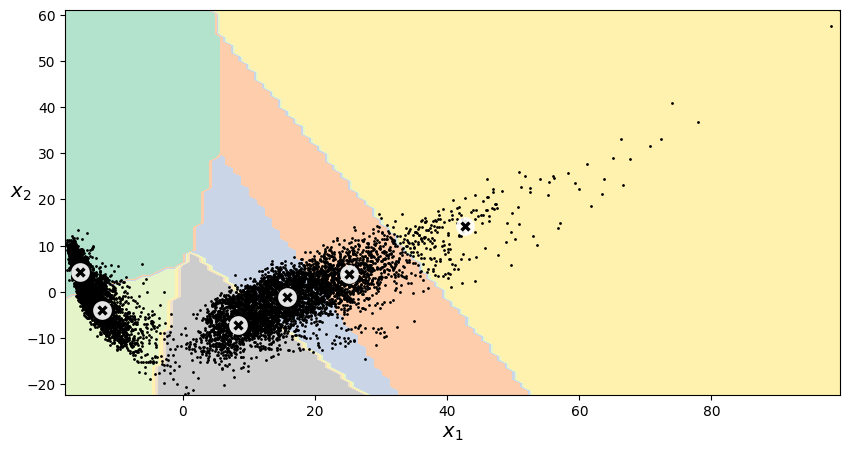

In [12]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf_kmeans, X_pca)
plt.show()

**KOMENTARZ: W mojej opinii na wykresie widać w sumie tylko dwa zbiory i wyżej wyświetlone 6 nie obrazują rzeczywistości.**

**[DBSCAN] - dokonajmy klasteryzacji za pomocą modelu - DBSCAN z parametrem: eps=0.5 i min_samples=10**

In [13]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(X_pca)

DBSCAN(min_samples=10)

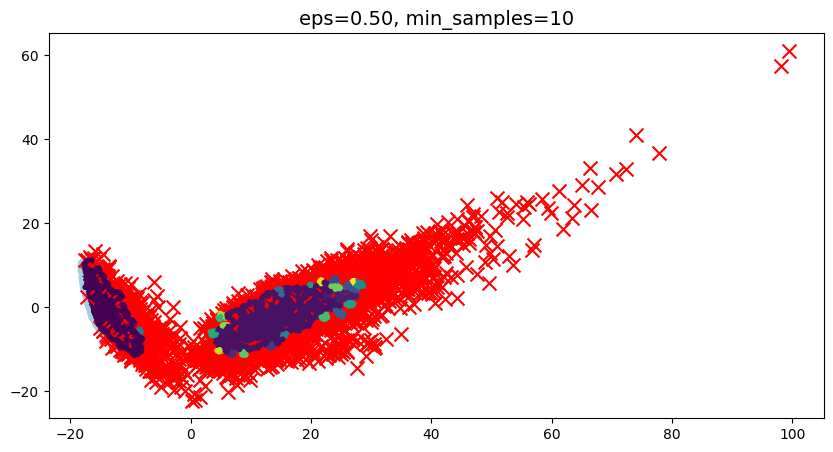

In [14]:
plt.figure(figsize=(10, 5))
plot_dbscan(dbscan, X_pca, size=100)
plt.show()

**KOMENTARZ: metoda klasteryzacji DBSCAN nie próbuje określić ilości klastrów w sposób numeryczny tylko jedynie w wsposób wizualny chce nam je przestawić. Jak wiadać na powyższych wykresach de facto możemy wyodrębnić dwa zbiory/ dwa klastry. P.S. Wykres troche przypowina znaczek nike ;)**

**[GMM] - dokonajmy klasteryzacji za pomocą modelu - GMM z hiperparametrami n-components=6 i n_init=100**

In [15]:
gmm = GaussianMixture(n_components=6, n_init=100)
gmm.fit(X_pca)

GaussianMixture(n_components=6, n_init=100)

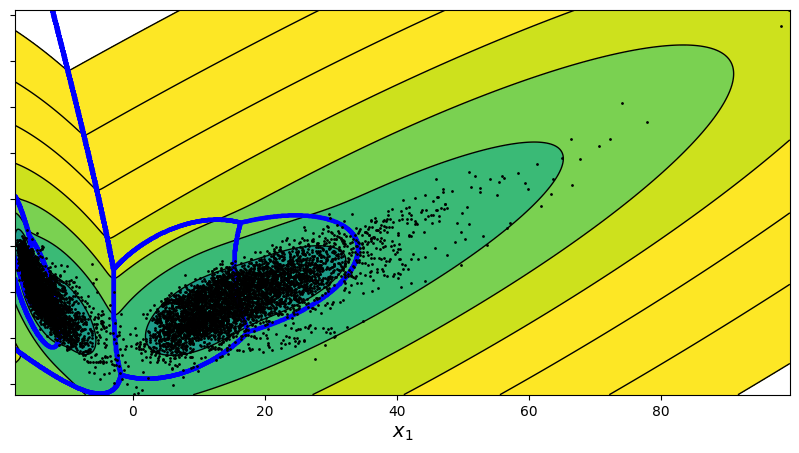

In [16]:
plt.figure(figsize=(10, 5))
plot_gaussian_mixture(gmm, X_pca)
plt.show()

**KOMENTARZ: model GMM przedstawia nam dwa klastry.**

**[PYTANIE] Z jakim typem czynności algorytmy poradziły sobie super, z jakim nie najlepiej. Typy czynności (dane zawarte w plikach *labels):**

1 - marsz, 
2 - wchodzenie w górę po schodach, 
3 – schodzenie w dół ze schodów, 
4 – siedzenie, 
5 – stanie, 
6 – leżenie.

**[KOMENTARZ] Aby odpowiedzieć na to pytanie należy zwizualizować dane na wykresie z podziałem na w/w czynności wg *labels**

**Tworzymy dataframe z dwiema głównymi składowymi [PC1, PC2] oraz labels, czyli aktywnościami (activity)**

In [17]:
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
datasets_pca = pd.concat([X_pca_df.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

**Tworzmy wizualizację na wykresie według w/w czynności**

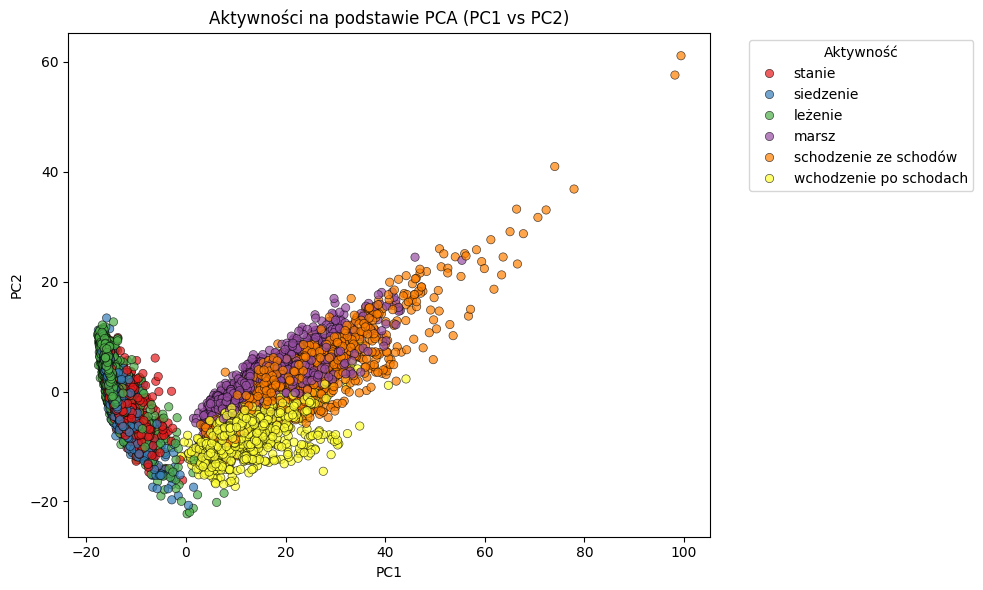

In [18]:
activity_labels = {
    1: 'marsz',
    2: 'wchodzenie po schodach',
    3: 'schodzenie ze schodów',
    4: 'siedzenie',
    5: 'stanie',
    6: 'leżenie'
}

df_plot = datasets_pca.copy()
df_plot['activity_label'] = df_plot['activity'].map(activity_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='PC1', y='PC2',
    hue='activity_label',
    palette='Set1',
    alpha=0.7,
    edgecolor='k'
)

plt.title('Aktywności na podstawie PCA (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Aktywność', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**KOMENTARZ: W mojej opinii żadna z metod klasteryzacji nie była w stanie prawidłowo określić prawidłowo 6 grup aktywności. Trzy wyżej badane czyli KMeans, DBSCAN i KNN były w stanie de facto odróżnić dwie grupy - PIERWSZĄ nazwijmy ją "spoczynkowa" czyli stanie, siedzenie i leżenie oraz DRUGĄ "aktywna" czyli marsz, schodzenie ze schodów, wchodzenie po schodach.**

**Dobieranie prawidłowej ilość klastrów dla KMeans - metodą łokcia (elbow method)**

In [19]:
k_means_per_k=[KMeans(n_clusters=k, random_state=1).fit(X_pca) for k in range(1,10)]
inertias = [model.inertia_ for model in k_means_per_k]

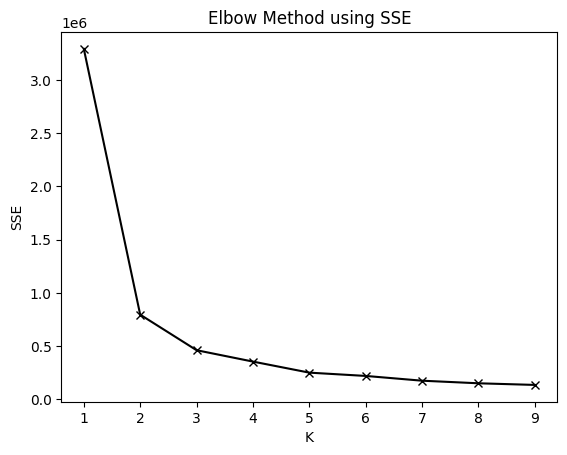

In [20]:
plt.plot(range(1,10), inertias, 'kx-')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title("Elbow Method using SSE")
plt.show()

**[KOMENTARZ] - metoda łokcia (elbow method) dla wyznaczania prawidłowej ilości klastrów określił nam, że prawidłowa ilość klastrów to 3.**

**Użyjmy jeszcze tzn. Silhouette_score do określenia prawidłowej ilości klastrów:**

In [21]:
silhouette_scores = [silhouette_score(X_pca, model.labels_)
                     for model in k_means_per_k[1:]]

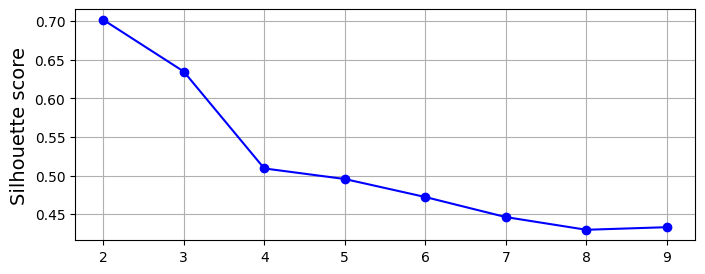

In [22]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

**KOMENTARZ: Prawidłowa ilość klastrów wg Silhouette_score to: 2**

Na danym zbiorze dokonaj preprocessingu, używając metod klasteringu. Następnie wyszkol dwa wybrane przez siebie klasyfikatory typu Supervised Learning i spróbuj uzyskać jak najlepszy wynik, używając wszystkich znanych sobie "wspomagaczy".

In [23]:
X_train_stratify, X_test_stratify, y_train_stratify, y_test_stratify = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

**Pipeline tylko z scalerem, kmeans i modelem logistic regression (v1)**

In [24]:
pipeline_LR_v1 = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(
        n_clusters=6,
        random_state=5
    )),
    ("log_reg", LogisticRegression(
        multi_class="ovr",
        max_iter=10000,
        random_state=5
    ))
])

pipeline_LR_v1.fit(X_train_stratify, y_train_stratify)

C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=6, random_state=5)),
                ('log_reg',
                 LogisticRegression(max_iter=10000, multi_class='ovr',
                                    random_state=5))])

**Pipeline tylko z scalerem, kmeans i modelem SVC (v1)**

In [25]:
pipeline_SVC_v1 = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(
        n_clusters=6,
        random_state=5
    )),
    ("svc", SVC(kernel='rbf', 
        gamma = 'auto',      
        random_state=5
    ))
])

pipeline_SVC_v1.fit(X_train_stratify, y_train_stratify)

C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=6, random_state=5)),
                ('svc', SVC(gamma='auto', random_state=5))])

**Trenowanie modeli ze scalerem oraz kmeans dla LR i SVC (v1) oraz wyniki dla zbioru testowego:**

In [26]:
print("Algorytm regresja logistyczna z preprocesingiem Scaler/KMeans - wynik:", pipeline_LR_v1.score(X_test_stratify, y_test_stratify))
print("Algorytm SVC z preprocesingiem Scaler/KMeans - wynik:", pipeline_SVC_v1.score(X_test_stratify, y_test_stratify))

Algorytm regresja logistyczna z preprocesingiem Scaler/KMeans - wynik: 0.6558252427184466
Algorytm SVC z preprocesingiem Scaler/KMeans - wynik: 0.6864077669902913


In [27]:
print(f'Słabe wyniki dla w/w modeli:\nLR (score): {round(pipeline_LR_v1.score(X_test_stratify, y_test_stratify),4)}\nSVC (score): {round(pipeline_SVC_v1.score(X_test_stratify, y_test_stratify),4)}')

Słabe wyniki dla w/w modeli:
LR (score): 0.6558
SVC (score): 0.6864


**Podejmujemy próbę uzyskania możliwie jak najlepszego wyniku trenowania dla w/w modeli**

**Tworzymy nowy pipeline (v2) z dodatkowych algorytmem PCA dla regresji logistycznej oraz więszką ilością hiperparametrów:**

In [28]:
pipeline_LR_v2 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)),
    ("kmeans", KMeans(
        n_clusters=6,
        random_state=5
    )),
    ("log_reg", LogisticRegression(
        multi_class="ovr",
        C=1,
        penalty='l1',
        solver='saga',
        max_iter=10000,
        random_state=5
    ))
])

pipeline_LR_v2.fit(X_train_stratify, y_train_stratify)

C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('kmeans', KMeans(n_clusters=6, random_state=5)),
                ('log_reg',
                 LogisticRegression(C=1, max_iter=10000, multi_class='ovr',
                                    penalty='l1', random_state=5,
                                    solver='saga'))])

**Tworzymy nowy pipeline (v2) z dodatkowych algorytmem PCA dla SVC oraz więszką ilością hiperparametrów:**

In [29]:
pipeline_SVC_v2 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.9)),
    ("kmeans", KMeans(
        n_clusters=6,
        random_state=5
    )),
    ("svc", SVC(kernel='rbf', 
        C=1.0,
        gamma = 'auto',      
        random_state=5
    ))
])

pipeline_SVC_v2.fit(X_train_stratify, y_train_stratify)

C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('kmeans', KMeans(n_clusters=6, random_state=5)),
                ('svc', SVC(gamma='auto', random_state=5))])

**Porównanie modelów bez redukcji wyniarów vs. z redukcją wymiarów (PCA/n-components=0.9)**

In [34]:
print(f'Porównanie modeli bez redukcji wymiarów i z redukcją wymiarów:\nLR (score): {round(pipeline_LR_v1.score(X_test_stratify, y_test_stratify),4)} vs. {round(pipeline_LR_v2.score(X_test_stratify, y_test_stratify), 4)} \nSVC (score): {round(pipeline_SVC_v1.score(X_test_stratify, y_test_stratify),4)} vs. {round(pipeline_SVC_v2.score(X_test_stratify, y_test_stratify), 4)}')
print(f'Okazuje się, że model LR lepiej sobie poradził bez redukcji wymiarów, natomiast SVC nieznacznie lepiej z redukcją wymiarów.')

Porównanie modeli bez redukcji wymiarów i z redukcją wymiarów:
LR (score): 0.6558 vs. 0.6112 
SVC (score): 0.6864 vs. 0.6908
Okazuje się, że model LR lepiej sobie poradził bez redukcji wymiarów, natomiast SVC nieznacznie lepiej z redukcją wymiarów.


**Tworzymy GridSearchCV dla modelu (v2) regresji logistycznej**

In [31]:
params = {
    'pca__n_components': [20, 30, 40],
    'kmeans__n_clusters': [15, 20, 25],
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__C': [1, 10, 15],
    'log_reg__solver': ['saga']
}

grid_search_LR = GridSearchCV(pipeline_LR_v2,
                           params,
                           cv=4,
                           n_jobs = -1,
                           verbose = 10,
                           scoring = 'accuracy')

grid_search_LR.fit(X_train_stratify, y_train_stratify)

print('Wybrane hiperparametry:', grid_search_LR.best_params_)

model_LR_GS_v2 = grid_search_LR.best_estimator_

print('Wynik model_LR_GS_v2 (score):', model_LR_GS_v2.score(X_test_stratify, y_test_stratify))

Fitting 4 folds for each of 54 candidates, totalling 216 fits


C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Wybrane hiperparametry: {'kmeans__n_clusters': 25, 'log_reg__C': 10, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga', 'pca__n_components': 30}
Wynik model_LR_GS_v2 (score): 0.8781553398058253


In [32]:
param_svc = {
    'pca__n_components': [2, 5, 10],
    'svc__kernel': ['rbf', 'linear'],
    'svc__C': [10, 20, 25],
    'svc__gamma': ['scale', 0.005, 0.01, 0.1]
}

grid_search_SVC_v2 = GridSearchCV(
                        pipeline_SVC_v2,
                        param_svc,
                        cv=4,
                        n_jobs=-1,
                        verbose=10,
                        scoring='accuracy'
)

grid_search_SVC_v2.fit(X_train_stratify, y_train_stratify)

print('Wybrane hiperparametry:', grid_search_SVC_v2.best_params_)

model_SVC_GS_v2 = grid_search_SVC_v2.best_estimator_

print('Wynik model_SVC_GS_v2:', model_SVC_GS_v2.score(X_test_stratify, y_test_stratify))

Fitting 4 folds for each of 72 candidates, totalling 288 fits


C:\projects\Wizualizacja_danych_cz1\env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wybrane hiperparametry: {'pca__n_components': 5, 'svc__C': 25, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Wynik model_SVC_GS_v2: 0.8388349514563107


**Pierwotne modele vs. ulepszone**

In [33]:
print('Podsumowanie:')
print(f'Model LR_v1 / Model LR_v2:\n'
      f'{round(pipeline_LR_v1.score(X_test_stratify, y_test_stratify), 4)} / '
      f'{round(model_LR_GS_v2.score(X_test_stratify, y_test_stratify), 4)}')

print(f'Model SVC_v1 / Model SVC_v2:\n'
      f'{round(pipeline_SVC_v1.score(X_test_stratify, y_test_stratify), 4)} / '
      f'{round(model_SVC_GS_v2.score(X_test_stratify, y_test_stratify), 4)}')

print('Możemy dostrzeć dość dużą poprawę wyników dla nowych modeli LR i SVC')

Podsumowanie:
Model LR_v1 / Model LR_v2:
0.6558 / 0.8782
Model SVC_v1 / Model SVC_v2:
0.6864 / 0.8388
Możemy dostrzeć dość dużą poprawę wyników dla nowych modeli LR i SVC


**Czym różni się KMeans, K-fold i K Nearest Neighbors?**

**[ODPOWIEDź]: Są to trzy różne algorytmy. KMeans to algorytm do klasteryzacji, w którym określamy w hiperparametrze ilość klastrów którą chcielibyśmy, aby model wyszukał. Algorytm działa tylko na zmiennych niezależnych tzn. bez tzn. labels/etykiet i jest modelem uczenia nienadzorowanego. Warto aby dane były zeskalowane. Natomiast K-fold jest to technika walidacji która ocenia skuteczność modelu lepiej niż podział train/test. I ostatnia, czyli KNN to algorytm uczenia nadzorowanego do klasyfikacji lub regresji może słuzyć do klasyfikacji np gatunków kwiatów, predykcji cen lub rozpoznawania obrazów. W każdym z powyższych technik występuje listera "K" gdzie w KMeans to ilość klastrów, K-fold liczna na którą dzielimy zbiór danych i KNN gdzie określa liczba tzw. sąsiadów**